# Verify fits using the halo catolog and the densities of clusters (ie. Coma Cluster) and compare to the SDSS fits. 

In [1]:
%matplotlib inline
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"
from matplotlib import pyplot as plt
import numpy as np
from pyslime import slime
from pyslime import utils as pu
import glob

import pandas as pd
import pickle

from astropy.table import Table, vstack
from astropy.cosmology import Planck15 as cosmo
from astropy.coordinates import SkyCoord
import astropy.units as u

plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 16

### bp halo file

In [2]:
bphalofile =  '/Users/mwilde/Dropbox/slime-mold/data/Bolshoi-Planck/bpdattrim_noDistCut.csv'
bphalos = pd.read_csv(bphalofile)

In [3]:
bphalos.M200b.max(), np.log10(bphalos.density_CIC.max())

(15.16, 5.409254773364251)

In [4]:
bphalos.query('M200b > 15')

,M200b,density_CIC,x_dist,y_dist,z_dist
116846,15.087,213803.72,-158.749,-134.504,225.407
2510282,15.160,256598.89,-111.501,61.480,136.684


In [5]:
xcart = bphalos.loc[bphalos.M200b.idxmax()].x_dist
ycart = bphalos.loc[bphalos.M200b.idxmax()].y_dist
zcart = bphalos.loc[bphalos.M200b.idxmax()].z_dist

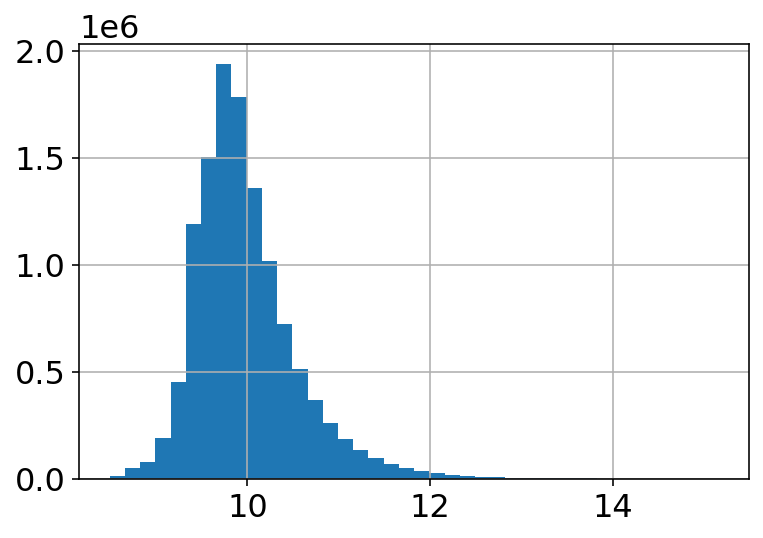

In [6]:
bphalos.M200b.hist(bins=40);

### coma cluster mass  $M_{200} \sim 10^{15} M_{\odot}$ 
https://iopscience.iop.org/article/10.1086/523101/pdf

# load in the bp sim to query density at location of large halos

In [8]:
bpDensityFile = '/Users/mwilde/Dropbox/slime-mold/data/final_data/BP_0214_densities_1024_0.bin'
rho_m = np.fromfile(bpDensityFile, dtype=np.float64)
rho_m = np.reshape(rho_m,(1024,1024,1024))

In [9]:
logrhom = np.log10(rho_m)

# load in bp-slime to compare

In [10]:
smdir = '../data/BP_z=0p0/'
bpslime_dir = '/Volumes/GoogleDrive/My Drive/SlimeMold/2021-10-12/BP_z=0_float32'
bpslime_datafile='trace_BP_z=0_float32.bin'
sdss_slime_dir = '/Volumes/GoogleDrive/My Drive/SlimeMold/2021-10-12/SDSS_z=0.1_float32'
sdss_datafile = 'trace_SDSS_z=0.1_float32.bin'

# bpslime_old = get_slime(smdir)
bpslime = pu.get_slime(bpslime_dir,
                         datafile=bpslime_datafile,
                         dtype=np.float32,
                         standardize=False)

(720, 720, 720) (0, 1, 2)
(720, 720, 720)


/Users/mwilde/python/pyslime/pyslime/utils.py:328: RuntimeWarning: divide by zero encountered in log10
  bpslime.data = np.log10(bpslime.data)


In [11]:
xidx, yidx, zidx = bpslime.cartesian_to_idx(np.array(bphalos.x_dist), np.array(bphalos.y_dist), np.array(bphalos.z_dist))
# xcut, ycut, zcut = [(idx < 1000) & (idx>24) for idx in (xidx, yidx, zidx)]
slimedens = bpslime.data[xidx, yidx, zidx]

In [12]:
from pyslime.pipeline import pipelineUtils as ppu

xdist, ydist, zdist = pu.idx_to_cartesian(
            xidx, yidx, zidx, slime=bpslime
        )



In [24]:

def find_nearest(array, value):
    idx = np.searchsorted(array, value, side="left")
    idx = idx - (np.abs(value - array[idx-1]) < np.abs(value - array[idx]))
    return idx


In [27]:
xycoords_rho = np.linspace(-125 / cosmo.h, 125.0 / cosmo.h, 1024)
zcoords_rho = np.linspace(0.0, 250.0 / cosmo.h, 1024)
fn_idx = find_nearest(xycoords_rho, xdist)

In [31]:
fn_idx

array([  87,   89,   90, ...,  907,  907, 1022])

In [28]:
ss_idx = np.searchsorted(xycoords_rho, xdist, side='right')

In [29]:
joes_idx = ppu.closest(xycoords_rho, xdist)

In [33]:
dif = np.abs(np.array(fn_idx) - np.array(joes_idx))
np.sum(dif), len(dif), len(joes_idx), len(ss_idx)


(0, 12085858, 12085858, 12085858)

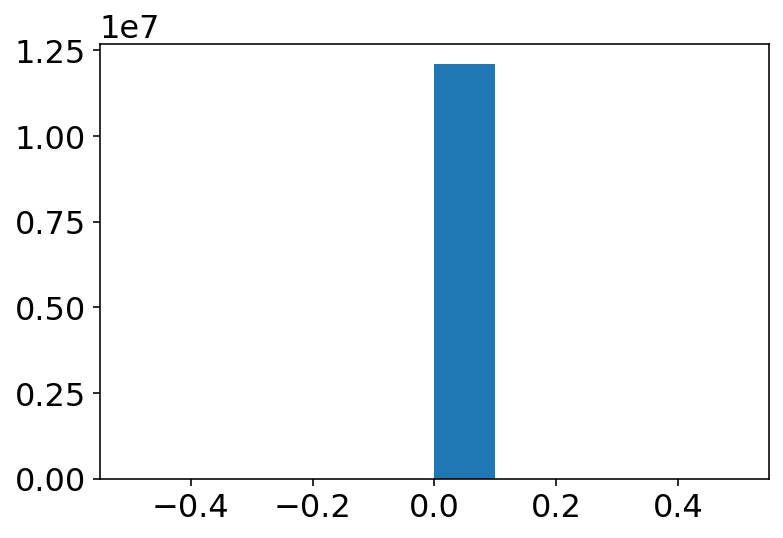

In [51]:
plt.hist(dif);

In [149]:


xycoords_rho = np.linspace(-125 / cosmo.h, 125.0 / cosmo.h, 1024)
zcoords_rho = np.linspace(0.0, 250.0 / cosmo.h, 1024)
x = np.array(bisection(xycoords_rho, xdist[0]), dtype=np.int32)
# y = int(ppu.closest(xycoords_rho, ydist))
# z = int(ppu.closest(zcoords_rho, zdist))

In [148]:
bpidx_x = np.zeros_like(xdist) 
bpidx_y = np.zeros_like(xdist)
bpidx_z = np.zeros_like(xdist)

for i in range(len(xdist)):
    bpidx_x[i], bpidx_y[i], bpidx_z[i] = ppu.bprho_dist_to_idx(xdist[i], ydist[i], zdist[i])

KeyboardInterrupt: 

In [107]:
xidx.max(), xidx.min(), bpslime.data[1024, 0, 0]

IndexError: index 1024 is out of bounds for axis 0 with size 1024

In [33]:
bpslime.data.shape

(1024, 1024, 1024)

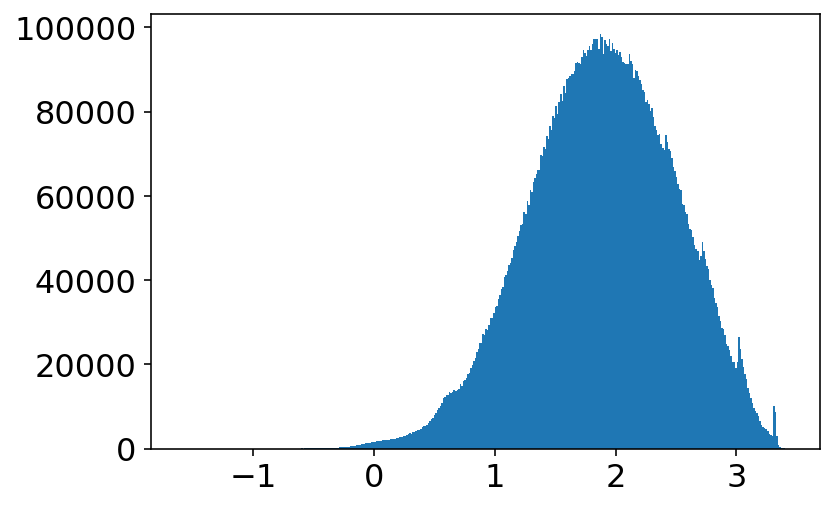

In [34]:
plt.hist(slimedens[~np.isinf(slimedens)], bins=400);

In [ ]:
bpdens = logrhom[bpidx_x, bpidx_y, bpidx_z]

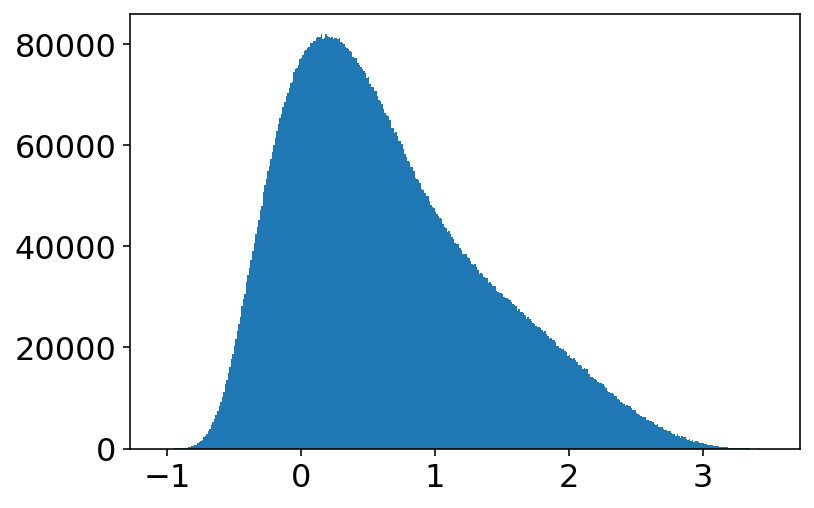

In [121]:
plt.hist(bpdens, bins=400);

# slime density at the largest halos in the BP sims

In [108]:
bphalos.loc[bphalos.M200b.idxmax()]

M200b              15.160
density_CIC    256598.890
x_dist           -111.501
y_dist             61.480
z_dist            136.684
Name: 2510282, dtype: float64

In [111]:
sdss['mhalo'].max()

15.99941950523551

In [114]:
xcart = bphalos.loc[bphalos.M200b.idxmax()].x_dist
ycart = bphalos.loc[bphalos.M200b.idxmax()].y_dist
zcart = bphalos.loc[bphalos.M200b.idxmax()].z_dist
xidx, yidx, zidx = bpslime.cartesian_to_idx(xcart, ycart, zcart)
slimedens = bpslime.data[xidx, yidx, zidx]
slimedens

3.4424798

In [115]:
logrhom[xidx, yidx, zidx]

3.495025029285177

# kernel density at that location

In [44]:
kernel_density = bphalos.loc[bphalos.M200b.idxmax()].density_CIC
np.log10(kernel_density)

5.409254773364251

# bp density at this location

In [48]:
bpdense = logrhom[xidx, yidx, zidx]
bpdense

3.495025029285177

# coma density from sdss-slime fits


In [130]:
sldat = pu.get_slime(sdss_slime_dir,
                         datafile=sdss_datafile,
                         dtype=np.float32,
                         standardize=True, stretch=0.61092954, shift=0.42016807)

(624, 1024, 608) (0, 1, 2)
(608, 1024, 624)


In [129]:
abelcoords = SkyCoord("11h44m36.5s +19d45m32", unit=(u.hourangle, u.deg))
comacoords = SkyCoord("12h59m48.7s +27d58m50s", unit=(u.hourangle, u.deg))

abel_ra = abelcoords.ra.deg
abel_dec = abelcoords.dec.deg
abel_z = 0.0217

coma_ra = comacoords.ra.deg
coma_dec = comacoords.dec.deg
coma_z = 0.023100

abel_dens = sldat.sky_to_data(abel_ra, abel_dec, abel_z)
coma_dens = sldat.sky_to_data(coma_ra, coma_dec, coma_z)

abel_dens, coma_dens

(4.761316, 4.8734574)

# check to see what the density is at the location of the most massive galaxy in sdss (should be the same?)

In [51]:
sdss = pd.read_csv('../data/sdssGalaxy_rsdCorr_dbscan_e2p0ms3_dz0p001_m10p0.csv')

In [52]:
coma_ra, coma_dec, coma_z, abel_ra, abel_dec, abel_z

(194.95291666666662,
 27.980555555555554,
 0.0231,
 176.1520833333333,
 19.75888888888889,
 0.0217)

In [112]:
# most massive galaxy
sdss.loc[sdss.mhalo.idxmax()]

mstars        12.093392
RA           208.621911
DEC            4.992535
Z              0.076129
NSAID     153759.000000
mhalo         15.999420
zadopt         0.076129
newz           0.000000
x_cart      -311.381887
y_cart      -169.925423
z_cart        30.988278
Name: 80701, dtype: float64

In [113]:
maxRA = sdss.loc[sdss.mhalo.idxmax()].RA
maxDEC = sdss.loc[sdss.mhalo.idxmax()].DEC
maxz = sdss.loc[sdss.mhalo.idxmax()].zadopt
sldat.sky_to_data(maxRA, maxDEC, maxz)

3.384174

In [55]:
maxRA = sdss.loc[sdss.mhalo.idxmax()].RA
maxDEC = sdss.loc[sdss.mhalo.idxmax()].DEC
maxz = sdss.loc[sdss.mhalo.idxmax()].zadopt
sldat.sky_to_data(maxRA, maxDEC, maxz)

3.384174

In [56]:
np.where(sldat.data == sldat.data.max())

(array([162, 184, 190, 203, 225, 248, 404, 426, 455, 493, 493, 497, 502,
        532, 543, 543, 543, 544, 544, 544, 544, 544, 545, 546, 546, 546,
        546, 547, 547, 547, 547, 548, 566]),
 array([553, 504, 623, 601, 547, 423, 310, 666, 648, 565, 630, 358, 656,
        470, 628, 628, 629, 627, 628, 628, 629, 629, 590, 589, 590, 590,
        591, 589, 590, 590, 591, 590, 445]),
 array([217, 135, 110, 121, 120, 123, 345, 240, 164, 228, 354, 225, 195,
        130, 149, 150, 150, 150, 149, 150, 149, 150, 170, 170, 169, 170,
        169, 170, 169, 170, 169, 169, 170]))

# check the mapping to see if its producing correct values

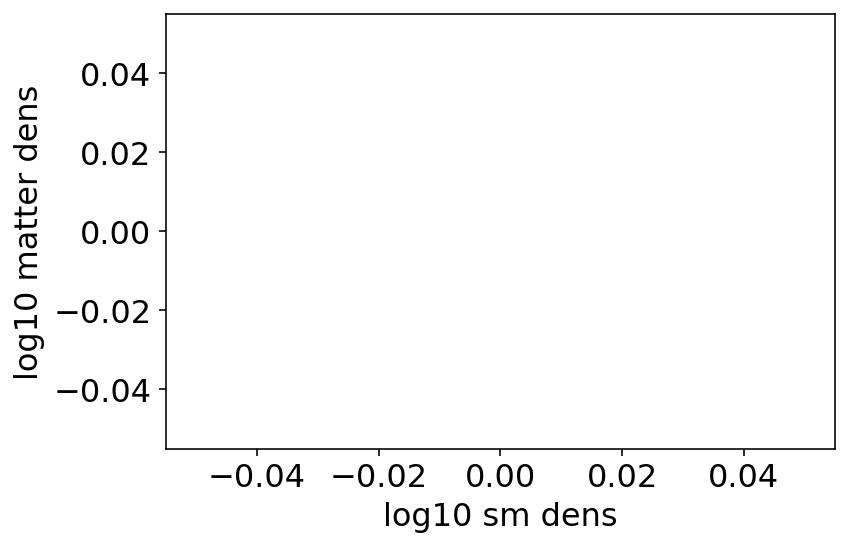

In [57]:
smpackage = pickle.load(open('mapping_BP_z0p0_1sigma.pick','rb'))
smrhobins = smpackage['smrhobins']
binsize = 0.1
midbins = smrhobins[:-1]+binsize/2.
with open('interpolator_z0p0.pkl', 'rb') as f:
    mapping_function = pickle.load(f)
plt.plot(midbins, mapping_function(midbins), '-', lw=1, alpha=0.7)
plt.xlabel('log10 sm dens')
plt.ylabel('log10 matter dens');

# map coma density

In [58]:
coma_dens, mapping_function(np.array([coma_dens]))

(3.538825, array([nan]))

In [59]:
mapping_function(3.5)

array(nan)